In [99]:
import pickle as pkl
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
idx2name = pkl.load(open('data/hierarchies/tieredimagenet/tieredimagenet_idx_to_name.pkl', 'rb'))
class2idx = pkl.load(open('data/hierarchies/tieredimagenet/tieredimagenet_class_to_idx.pkl', 'rb'))

In [86]:
from torchvision import transforms

In [87]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
t = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])

In [88]:
# open ILSVRC2012_val_00047737.JPEG and apply the transform
from PIL import Image
img = Image.open('ILSVRC2012_val_00047737.JPEG')
img = t(img)

imgs_blurred = [img]

for sigma in np.linspace(1/10, 10, 100):
    t_blurred = transforms.GaussianBlur(kernel_size=61, sigma=sigma)
    img_blurred = t_blurred(img)
    imgs_blurred.append(img_blurred)
imgs_blurred = torch.stack(imgs_blurred)

In [89]:
from torchvision.models import (
    alexnet, AlexNet_Weights,
    convnext_tiny, ConvNeXt_Tiny_Weights,
    densenet121, DenseNet121_Weights,
    efficientnet_v2_s, EfficientNet_V2_S_Weights,
    inception_v3, Inception_V3_Weights,
    resnet18, ResNet18_Weights,
    swin_v2_t, Swin_V2_T_Weights,
    vgg11, VGG11_Weights,
    vit_b_16, ViT_B_16_Weights,
)

In [90]:
MODEL_REGISTRY = {
    'alexnet': (alexnet, AlexNet_Weights),
    'convnext_tiny': (convnext_tiny, ConvNeXt_Tiny_Weights),
    'densenet121': (densenet121, DenseNet121_Weights),
    'efficientnet_v2_s': (efficientnet_v2_s, EfficientNet_V2_S_Weights),
    'inception_v3': (inception_v3, Inception_V3_Weights),
    'resnet18': (resnet18, ResNet18_Weights),
    'swin_v2_t': (swin_v2_t, Swin_V2_T_Weights),
    'vgg11': (vgg11, VGG11_Weights),
    'vit_b_16': (vit_b_16, ViT_B_16_Weights),
}

In [91]:
def get_pretrained_model(model_name: str):
    """
    Return a model constructor and weights given a model name.
    """
    if model_name not in MODEL_REGISTRY:
        raise ValueError(f"Unknown model '{model_name}'. Available: {list(MODEL_REGISTRY)}")

    constructor, weights_cls = MODEL_REGISTRY[model_name]
    return constructor, weights_cls


In [92]:
model_constructor, weights_cls = get_pretrained_model('vgg11')
weights = weights_cls.IMAGENET1K_V1
model = model_constructor(weights=weights)

In [93]:
idx_mapping = pkl.load(open('data/hierarchies/tieredimagenet/tiredimagenet_corresponding_index.pkl', 'rb'))

In [94]:
model.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [95]:
indices = [idx_mapping[key] for key in idx_mapping]
indices = torch.tensor(indices, dtype=torch.long)

# Get original weights and bias
old_weight = model.classifier[6].weight.data
old_bias = model.classifier[6].bias.data

# Prune
new_weight = old_weight[indices]
new_bias = old_bias[indices]

# Replace parameters
model.classifier[6].weight = nn.Parameter(new_weight)
model.classifier[6].bias = nn.Parameter(new_bias)
model.classifier[6].out_features = len(indices)

In [96]:
proba_leaves = model.forward(imgs_blurred)

In [100]:
# apply softmax to axis 1
proba_leaves = F.softmax(proba_leaves, dim=1)
proba_leaves = proba_leaves.detach().cpu().numpy()

In [101]:
import hierulz.hierarchy.hierarchy as hhh
import importlib
importlib.reload(hhh)

<module 'hierulz.hierarchy.hierarchy' from '/home/infres/rplaud/hierarchical_decision_rules/hierulz/hierarchy/hierarchy.py'>

In [102]:
from hierulz.hierarchy import Hierarchy, load_hierarchy


In [103]:
h = load_hierarchy('data/hierarchies/tieredimagenet/tieredimagenet_hierarchy_idx.pkl')

In [104]:
proba_nodes = h.get_probas(proba_leaves)

In [105]:
from hierulz.metrics import load_metric, hFBetaScore, Accuracy
from hierulz.heuristics import TopDown, Plurality

In [106]:
m = hFBetaScore(hierarchy=h, beta=1.0)
argmax = Accuracy(hierarchy=h)
top_down_heuristic = TopDown(hierarchy=h)
plurality_heuristic = Plurality(hierarchy=h)

In [107]:
pred_opt = m.decode(proba_nodes)

In [108]:
pred_argmax = argmax.decode(proba_nodes)

In [109]:
pred_top_down = top_down_heuristic.decode(proba_nodes)
pred_plurality = plurality_heuristic.decode(proba_nodes)

In [118]:
def decode_pred(pred, h, idx2name):
    labels = np.where(pred)[0]
    pred = [h.root_idx]
    bool=True
    while bool:
        bool_i = False
        for l in pred:
            if l in h.leaves_idx:
                pass
            # del l from pred and add the children of l to pred
            else :
                inter = list(set(h.hierarchy_dico_idx[l]).intersection(set(labels)))
                if len(inter) > 0:
                    pred.remove(l)
                    pred.extend(inter)
                    bool_i = True
        bool = bool_i
    return [idx2name[p] for p in pred]


In [119]:
h.hierarchy_dico_idx[h.root_idx]

[747, 733]

In [120]:
proba_nodes[0]

array([3.26842975e-09, 2.93619989e-10, 3.89275695e-10, 2.98391756e-10,
       1.22322064e-09, 1.52681903e-08, 1.77914856e-08, 1.84502205e-11,
       1.79043065e-11, 4.76494582e-12, 7.85692171e-12, 2.84550838e-11,
       1.85215853e-11, 1.08325978e-11, 4.11508577e-10, 5.18713093e-11,
       5.72233103e-12, 1.55448755e-12, 2.97110253e-12, 6.42279493e-11,
       1.43486034e-09, 3.95521879e-11, 5.51969581e-10, 4.07669648e-10,
       2.77306806e-11, 7.02858327e-11, 1.73031880e-10, 3.30286874e-11,
       4.18552137e-10, 2.25878094e-10, 4.30618624e-10, 4.15684848e-10,
       1.37494727e-09, 1.81986912e-10, 7.43617667e-11, 7.92513555e-11,
       3.60287888e-09, 8.86965168e-08, 1.95133829e-08, 1.68481340e-09,
       4.42651193e-10, 8.79909567e-09, 1.63923000e-10, 6.91224522e-10,
       1.03198667e-08, 2.22108262e-10, 2.93492314e-10, 4.65119540e-11,
       9.72661840e-10, 8.82805148e-11, 1.58614386e-10, 3.40817305e-12,
       4.94838415e-12, 4.87968554e-11, 5.89480678e-12, 9.04923098e-12,
      

In [122]:
y_pred = [decode_pred(pred_opt[i], h, idx2name) for i in range(len(pred_opt))]
y_pred_argmax = [decode_pred(pred_argmax[i], h, idx2name) for i in range(len(pred_argmax))]
y_pred_top_down = [decode_pred(pred_top_down[i], h, idx2name) for i in range(len(pred_top_down))]
y_pred_plurality = [decode_pred(pred_plurality[i], h, idx2name) for i in range(len(pred_plurality))]

In [159]:
import matplotlib.pyplot as plt
from torchvision.transforms import functional as f


In [183]:
imgs_blurred_np = []
for i in range(len(imgs_blurred)):
    img_np = ((imgs_blurred[i] - imgs_blurred[i].min()) / (imgs_blurred[i].max() - imgs_blurred[i].min())).numpy()
    imgs_blurred_np.append(img_np.transpose(1, 2, 0))
imgs_blurred_np = np.array(imgs_blurred_np)

In [184]:
def plot_image_with_pred(img, pred):
    plt.imshow(img)
    plt.title(', '.join(pred))
    plt.axis('off')
    plt.show()

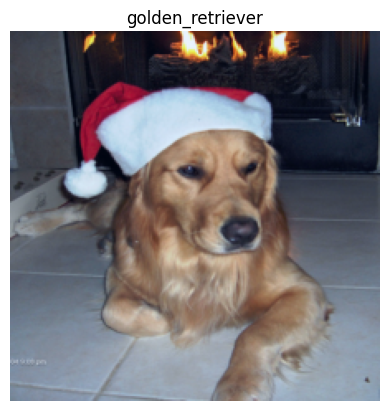

In [185]:
plot_image_with_pred(imgs_blurred_np[0], y_pred[0])

In [180]:
imgs_blurred_np = (imgs_blurred - imgs_blurred.min(axis=(1, 2, 3), keepdims=True)) / (imgs_blurred.max(axis=(1, 2, 3), keepdims=True) - imgs_blurred.min(axis=(1, 2, 3), keepdims=True)).numpy()

TypeError: min() received an invalid combination of arguments - got (keepdims=bool, axis=tuple, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: keepdims, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: keepdims, axis


In [176]:
plot_image_with_pred(img_blurred[0], y_pred[0])

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3